In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import metrics
import statistics
import copy
import math
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy import integrate
from scipy.integrate import solve_ivp

In [72]:
import numpy as np
from scipy.integrate import solve_ivp

# Function to integrate
def f(x):
    return x**2

# Starting value for IVP
x = [2]

# Can replace 10 with number of times you want to iterate through
for i in range(10):
    
    # For unexpected values, replace x[-1] with new value
    sol = solve_ivp(lambda x, t: f(x), [i, i+1], [x[-1]], rtol = 1e-5)

    print(sol.y[0][-1])
    x.append(sol.y[0][-1])



2.333333333333334
4.666666666666667
11.0
23.333333333333336
43.66666666666667
74.0
116.33333333333331
172.66666666666663
244.99999999999994
335.3333333333333


In [73]:
"""
Code from Modeling and Simulation in Python.

Copyright 2020 Allen Downey

MIT License: https://opensource.org/licenses/MIT
"""

import logging

logger = logging.getLogger(name="modsim.py")

# make sure we have Python 3.6 or better
import sys

if sys.version_info < (3, 6):
    logger.warning("modsim.py depends on Python 3.6 features.")

import inspect

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

import scipy.optimize as spo

from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline

from scipy.integrate import solve_ivp

from types import SimpleNamespace
from copy import copy


def flip(p=0.5):
    """Flips a coin with the given probability.

    p: float 0-1

    returns: boolean (True or False)
    """
    return np.random.random() < p


def cart2pol(x, y, z=None):
    """Convert Cartesian coordinates to polar.

    x: number or sequence
    y: number or sequence
    z: number or sequence (optional)

    returns: theta, rho OR theta, rho, z
    """
    x = np.asarray(x)
    y = np.asarray(y)

    rho = np.hypot(x, y)
    theta = np.arctan2(y, x)

    if z is None:
        return theta, rho
    else:
        return theta, rho, z


def pol2cart(theta, rho, z=None):
    """Convert polar coordinates to Cartesian.

    theta: number or sequence in radians
    rho: number or sequence
    z: number or sequence (optional)

    returns: x, y OR x, y, z
    """
    x = rho * np.cos(theta)
    y = rho * np.sin(theta)

    if z is None:
        return x, y
    else:
        return x, y, z

from numpy import linspace

def linrange(start, stop=None, step=1, **options):
    """Make an array of equally spaced values.

    start: first value
    stop: last value (might be approximate)
    step: difference between elements (should be consistent)

    returns: NumPy array
    """
    if stop is None:
        stop = start
        start = 0
    n = int(round((stop-start) / step))
    return linspace(start, stop, n+1, **options)


def root_scalar(func, *args, **kwargs):
    """Finds the input value that minimizes `min_func`.

    Wrapper for
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root_scalar.html

    func: computes the function to be minimized
    bracket: sequence of two values, lower and upper bounds of the range to be searched
    args: any additional positional arguments are passed to func
    kwargs: any keyword arguments are passed to root_scalar

    returns: RootResults object
    """
    bracket = kwargs.get('bracket', None)
    if bracket is None or len(bracket) != 2:
        msg = ("To run root_scalar, you have to provide a "
               "`bracket` keyword argument with a sequence "
               "of length 2.")
        raise ValueError(msg)

    try:
        func(bracket[0], *args)
    except Exception as e:
        msg = ("Before running scipy.integrate.root_scalar "
               "I tried running the function you provided "
               "with `bracket[0]`, "
               "and I got the following error:")
        logger.error(msg)
        raise (e)

    underride(kwargs, rtol=1e-4)

    res = spo.root_scalar(func, *args, **kwargs)

    if not res.converged:
        msg = ("scipy.optimize.root_scalar did not converge. "
               "The message it returned is:\n" + res.flag)
        raise ValueError(msg)

    return res


def minimize_scalar(func, *args, **kwargs):
    """Finds the input value that minimizes `func`.

    Wrapper for
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html

    func: computes the function to be minimized
    args: any additional positional arguments are passed to func
    kwargs: any keyword arguments are passed to minimize_scalar

    returns: OptimizeResult object
    """
    bounds = kwargs.get('bounds', None)

    if bounds is None or len(bounds) != 2:
        msg = ("To run maximize_scalar or minimize_scalar, "
               "you have to provide a `bounds` "
               "keyword argument with a sequence "
               "of length 2.")
        raise ValueError(msg)

    try:
        func(bounds[0], *args)
    except Exception as e:
        msg = ("Before running scipy.integrate.minimize_scalar, "
               "I tried running the function you provided "
               "with the lower bound, "
               "and I got the following error:")
        logger.error(msg)
        raise (e)

    underride(kwargs, method='bounded')

    res = spo.minimize_scalar(func, args=args, **kwargs)

    if not res.success:
        msg = ("minimize_scalar did not succeed."
               "The message it returned is: \n" +
               res.message)
        raise Exception(msg)

    return res


def maximize_scalar(max_func, *args, **kwargs):
    """Finds the input value that maximizes `max_func`.

    Wrapper for https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html

    min_func: computes the function to be maximized
    args: any additional positional arguments are passed to max_func
    options: any keyword arguments are passed as options to minimize_scalar

    returns: ModSimSeries object
    """
    def min_func(*args):
        return -max_func(*args)

    res = minimize_scalar(min_func, *args, **kwargs)

    # we have to negate the function value before returning res
    res.fun = -res.fun
    return res


def run_solve_ivp(system, slope_func, **options):
    """Computes a numerical solution to a differential equation.

    `system` must contain `init` with initial conditions,
    `t_end` with the end time.  Optionally, it can contain
    `t_0` with the start time.

    It should contain any other parameters required by the
    slope function.

    `options` can be any legal options of `scipy.integrate.solve_ivp`

    system: System object
    slope_func: function that computes slopes

    returns: TimeFrame
    """
    system = remove_units(system)

    # make sure `system` contains `init`
    if not hasattr(system, "init"):
        msg = """It looks like `system` does not contain `init`
                 as a system variable.  `init` should be a State
                 object that specifies the initial condition:"""
        raise ValueError(msg)

    # make sure `system` contains `t_end`
    if not hasattr(system, "t_end"):
        msg = """It looks like `system` does not contain `t_end`
                 as a system variable.  `t_end` should be the
                 final time:"""
        raise ValueError(msg)

    # the default value for t_0 is 0
    t_0 = getattr(system, "t_0", 0)

    # try running the slope function with the initial conditions
    try:
        slope_func(t_0, system.init, system)
    except Exception as e:
        msg = """Before running scipy.integrate.solve_ivp, I tried
                 running the slope function you provided with the
                 initial conditions in `system` and `t=t_0` and I got
                 the following error:"""
        logger.error(msg)
        raise (e)

    # get the list of event functions
    events = options.get('events', [])

    # if there's only one event function, put it in a list
    try:
        iter(events)
    except TypeError:
        events = [events]

    for event_func in events:
        # make events terminal unless otherwise specified
        if not hasattr(event_func, 'terminal'):
            event_func.terminal = True

        # test the event function with the initial conditions
        try:
            event_func(t_0, system.init, system)
        except Exception as e:
            msg = """Before running scipy.integrate.solve_ivp, I tried
                     running the event function you provided with the
                     initial conditions in `system` and `t=t_0` and I got
                     the following error:"""
            logger.error(msg)
            raise (e)

    # get dense output unless otherwise specified
    if not 't_eval' in options:
        underride(options, dense_output=True)

    # run the solver
    bunch = solve_ivp(slope_func, [t_0, system.t_end], system.init,
                      args=[system], **options)

    # separate the results from the details
    y = bunch.pop("y")
    t = bunch.pop("t")

    # get the column names from `init`, if possible
    if hasattr(system.init, 'index'):
        columns = system.init.index
    else:
        columns = range(len(system.init))

    # evaluate the results at equally-spaced points
    if options.get('dense_output', False):
        try:
            num = system.num
        except AttributeError:
            num = 101
        t_final = t[-1]
        t_array = linspace(t_0, t_final, num)
        y_array = bunch.sol(t_array)

        # pack the results into a TimeFrame
        results = TimeFrame(y_array.T, index=t_array,
                        columns=columns)
    else:
        results = TimeFrame(y.T, index=t,
                        columns=columns)

    return results, bunch


def leastsq(error_func, x0, *args, **options):
    """Find the parameters that yield the best fit for the data.

    `x0` can be a sequence, array, Series, or Params

    Positional arguments are passed along to `error_func`.

    Keyword arguments are passed to `scipy.optimize.leastsq`

    error_func: function that computes a sequence of errors
    x0: initial guess for the best parameters
    args: passed to error_func
    options: passed to leastsq

    :returns: Params object with best_params and ModSimSeries with details
    """
    # override `full_output` so we get a message if something goes wrong
    options["full_output"] = True

    # run leastsq
    t = scipy.optimize.leastsq(error_func, x0=x0, args=args, **options)
    best_params, cov_x, infodict, mesg, ier = t

    # pack the results into a ModSimSeries object
    details = SimpleNamespace(cov_x=cov_x,
                              mesg=mesg,
                              ier=ier,
                              **infodict)
    details.success = details.ier in [1,2,3,4]

    # if we got a Params object, we should return a Params object
    if isinstance(x0, Params):
        best_params = Params(pd.Series(best_params, x0.index))

    # return the best parameters and details
    return best_params, details


def crossings(series, value):
    """Find the labels where the series passes through value.

    The labels in series must be increasing numerical values.

    series: Series
    value: number

    returns: sequence of labels
    """
    values = series.values - value
    interp = InterpolatedUnivariateSpline(series.index, values)
    return interp.roots()


def has_nan(a):
    """Checks whether the an array contains any NaNs.

    :param a: NumPy array or Pandas Series
    :return: boolean
    """
    return np.any(np.isnan(a))


def is_strictly_increasing(a):
    """Checks whether the elements of an array are strictly increasing.

    :param a: NumPy array or Pandas Series
    :return: boolean
    """
    return np.all(np.diff(a) > 0)


def interpolate(series, **options):
    """Creates an interpolation function.

    series: Series object
    options: any legal options to scipy.interpolate.interp1d

    returns: function that maps from the index to the values
    """
    if has_nan(series.index):
        msg = """The Series you passed to interpolate contains
                 NaN values in the index, which would result in
                 undefined behavior.  So I'm putting a stop to that."""
        raise ValueError(msg)

    if not is_strictly_increasing(series.index):
        msg = """The Series you passed to interpolate has an index
                 that is not strictly increasing, which would result in
                 undefined behavior.  So I'm putting a stop to that."""
        raise ValueError(msg)

    # make the interpolate function extrapolate past the ends of
    # the range, unless `options` already specifies a value for `fill_value`
    underride(options, fill_value="extrapolate")

    # call interp1d, which returns a new function object
    x = series.index
    y = series.values
    interp_func = interp1d(x, y, **options)
    return interp_func


def interpolate_inverse(series, **options):
    """Interpolate the inverse function of a Series.

    series: Series object, represents a mapping from `a` to `b`
    options: any legal options to scipy.interpolate.interp1d

    returns: interpolation object, can be used as a function
             from `b` to `a`
    """
    inverse = pd.Series(series.index, index=series.values)
    interp_func = interpolate(inverse, **options)
    return interp_func


def gradient(series, **options):
    """Computes the numerical derivative of a series.

    If the elements of series have units, they are dropped.

    series: Series object
    options: any legal options to np.gradient

    returns: Series, same subclass as series
    """
    x = series.index
    y = series.values

    a = np.gradient(y, x, **options)
    return series.__class__(a, series.index)


def source_code(obj):
    """Prints the source code for a given object.

    obj: function or method object
    """
    print(inspect.getsource(obj))


def underride(d, **options):
    """Add key-value pairs to d only if key is not in d.

    If d is None, create a new dictionary.

    d: dictionary
    options: keyword args to add to d
    """
    if d is None:
        d = {}

    for key, val in options.items():
        d.setdefault(key, val)

    return d


def contour(df, **options):
    """Makes a contour plot from a DataFrame.

    Wrapper for plt.contour
    https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.contour.html

    Note: columns and index must be numerical

    df: DataFrame
    options: passed to plt.contour
    """
    fontsize = options.pop("fontsize", 12)
    underride(options, cmap="viridis")
    x = df.columns
    y = df.index
    X, Y = np.meshgrid(x, y)
    cs = plt.contour(X, Y, df, **options)
    plt.clabel(cs, inline=1, fontsize=fontsize)


def savefig(filename, **options):
    """Save the current figure.

    Keyword arguments are passed along to plt.savefig

    https://matplotlib.org/api/_as_gen/matplotlib.pyplot.savefig.html

    filename: string
    """
    print("Saving figure to file", filename)
    plt.savefig(filename, **options)


def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()


def remove_from_legend(bad_labels):
    """Removes some labels from the legend.

    bad_labels: sequence of strings
    """
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in bad_labels:
            handle_list.append(handle)
            label_list.append(label)
    ax.legend(handle_list, label_list)


class SettableNamespace(SimpleNamespace):
    """Contains a collection of parameters.

    Used to make a System object.

    Takes keyword arguments and stores them as attributes.
    """
    def __init__(self, namespace=None, **kwargs):
        super().__init__()
        if namespace:
            self.__dict__.update(namespace.__dict__)
        self.__dict__.update(kwargs)

    def get(self, name, default=None):
        """Look up a variable.

        name: string varname
        default: value returned if `name` is not present
        """
        try:
            return self.__getattribute__(name, default)
        except AttributeError:
            return default

    def set(self, **variables):
        """Make a copy and update the given variables.

        returns: Params
        """
        new = copy(self)
        new.__dict__.update(variables)
        return new


def magnitude(x):
    """Returns the magnitude of a Quantity or number.

    x: Quantity or number

    returns: number
    """
    return x.magnitude if hasattr(x, 'magnitude') else x


def remove_units(namespace):
    """Removes units from the values in a Namespace.

    Only removes units from top-level values;
    does not traverse nested values.

    returns: new Namespace object
    """
    res = copy(namespace)
    for label, value in res.__dict__.items():
        if isinstance(value, pd.Series):
            value = remove_units_series(value)
        res.__dict__[label] = magnitude(value)
    return res


def remove_units_series(series):
    """Removes units from the values in a Series.

    Only removes units from top-level values;
    does not traverse nested values.

    returns: new Series object
    """
    res = copy(series)
    for label, value in res.iteritems():
        res[label] = magnitude(value)
    return res


class System(SettableNamespace):
    """Contains system parameters and their values.

    Takes keyword arguments and stores them as attributes.
    """
    pass


class Params(SettableNamespace):
    """Contains system parameters and their values.

    Takes keyword arguments and stores them as attributes.
    """
    pass


def State(**variables):
    """Contains the values of state variables."""
    return pd.Series(variables, name='state')


def make_series(x, y, **options):
    """Make a Pandas Series.

    x: sequence used as the index
    y: sequence used as the values

    returns: Pandas Series
    """
    underride(options, name='values')
    if isinstance(y, pd.Series):
        y = y.values
    series = pd.Series(y, index=x, **options)
    series.index.name = 'index'
    return series


def TimeSeries(*args, **kwargs):
    """
    """
    if args or kwargs:
        series = pd.Series(*args, **kwargs)
    else:
        series = pd.Series([], dtype=np.float64)

    series.index.name = 'Time'
    if 'name' not in kwargs:
        series.name = 'Quantity'
    return series


def SweepSeries(*args, **kwargs):
    """
    """
    if args or kwargs:
        series = pd.Series(*args, **kwargs)
    else:
        series = pd.Series([], dtype=np.float64)

    series.index.name = 'Parameter'
    if 'name' not in kwargs:
        series.name = 'Metric'
    return series


def show(obj):
    """Display a Series or Namespace as a DataFrame."""
    if isinstance(obj, pd.Series):
        df = pd.DataFrame(obj)
        return df
    elif hasattr(obj, '__dict__'):
        return pd.DataFrame(pd.Series(obj.__dict__),
                            columns=['value'])
    else:
        return obj


def TimeFrame(*args, **kwargs):
    """DataFrame that maps from time to State.
    """
    underride(kwargs, dtype=float)
    return pd.DataFrame(*args, **kwargs)


def SweepFrame(*args, **kwargs):
    """DataFrame that maps from parameter value to SweepSeries.
    """
    underride(kwargs, dtype=float)
    return pd.DataFrame(*args, **kwargs)


def Vector(x, y, z=None, **options):
    """
    """
    underride(options, name='component')
    if z is None:
        return pd.Series(dict(x=x, y=y), **options)
    else:
        return pd.Series(dict(x=x, y=y, z=z), **options)


## Vector functions (should work with any sequence)

def vector_mag(v):
    """Vector magnitude."""
    return np.sqrt(np.dot(v, v))


def vector_mag2(v):
    """Vector magnitude squared."""
    return np.dot(v, v)


def vector_angle(v):
    """Angle between v and the positive x axis.

    Only works with 2-D vectors.

    returns: angle in radians
    """
    assert len(v) == 2
    x, y = v
    return np.arctan2(y, x)


def vector_polar(v):
    """Vector magnitude and angle.

    returns: (number, angle in radians)
    """
    return vector_mag(v), vector_angle(v)


def vector_hat(v):
    """Unit vector in the direction of v.

    returns: Vector or array
    """
    # check if the magnitude of the Quantity is 0
    mag = vector_mag(v)
    if mag == 0:
        return v
    else:
        return v / mag


def vector_perp(v):
    """Perpendicular Vector (rotated left).

    Only works with 2-D Vectors.

    returns: Vector
    """
    assert len(v) == 2
    x, y = v
    return Vector(-y, x)


def vector_dot(v, w):
    """Dot product of v and w.

    returns: number or Quantity
    """
    return np.dot(v, w)


def vector_cross(v, w):
    """Cross product of v and w.

    returns: number or Quantity for 2-D, Vector for 3-D
    """
    res = np.cross(v, w)

    if len(v) == 3:
        return Vector(*res)
    else:
        return res


def vector_proj(v, w):
    """Projection of v onto w.

    returns: array or Vector with direction of w and units of v.
    """
    w_hat = vector_hat(w)
    return vector_dot(v, w_hat) * w_hat


def scalar_proj(v, w):
    """Returns the scalar projection of v onto w.

    Which is the magnitude of the projection of v onto w.

    returns: scalar with units of v.
    """
    return vector_dot(v, vector_hat(w))


def vector_dist(v, w):
    """Euclidean distance from v to w, with units."""
    if isinstance(v, list):
        v = np.asarray(v)
    return vector_mag(v - w)


def vector_diff_angle(v, w):
    """Angular difference between two vectors, in radians.
    """
    if len(v) == 2:
        return vector_angle(v) - vector_angle(w)
    else:
        # TODO: see http://www.euclideanspace.com/maths/algebra/
        # vectors/angleBetween/
        raise NotImplementedError()


def plot_segment(A, B, **options):
    """Plots a line segment between two Vectors.

    For 3-D vectors, the z axis is ignored.

    Additional options are passed along to plot().

    A: Vector
    B: Vector
    """
    xs = A.x, B.x
    ys = A.y, B.y
    plt.plot(xs, ys, **options)


from time import sleep
from IPython.display import clear_output

def animate(results, draw_func, *args, interval=None):
    """Animate results from a simulation.

    results: TimeFrame
    draw_func: function that draws state
    interval: time between frames in seconds
    """
    plt.figure()
    try:
        for t, state in results.iterrows():
            draw_func(t, state, *args)
            plt.show()
            if interval:
                sleep(interval)
            clear_output(wait=True)
        draw_func(t, state, *args)
        plt.show()
    except KeyboardInterrupt:
        pass


(5.684341886080802e-14, -86.4152764272615)

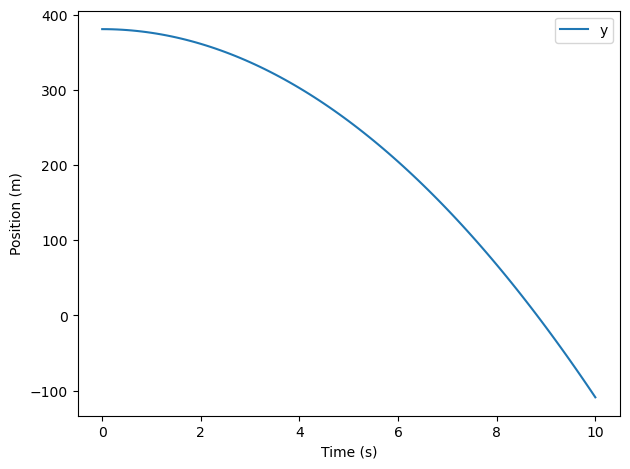

In [74]:
init = State(y=381, v=0)

system = System(init=init, 
                g=9.8, 
                t_end=10)

def slope_func(t, state, system):
    y, v = state

    dydt = v
    dvdt = -system.g
    
    return dydt, dvdt

dydt, dvdt = slope_func(0, system.init, system)
dydt, dvdt

results, details = run_solve_ivp(system, slope_func)
details.message

results.head()

results.y.plot()

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

results.iloc[-1].y

t_crossings = crossings(results.y, 0)
t_crossings

def event_func(t, state, system):
    y, v = state
    return y

results, details = run_solve_ivp(system, slope_func,
                                 events=event_func)
details.message

t_end = results.index[-1]
t_end

y, v = results.iloc[-1]
y, v

22.43946505804431

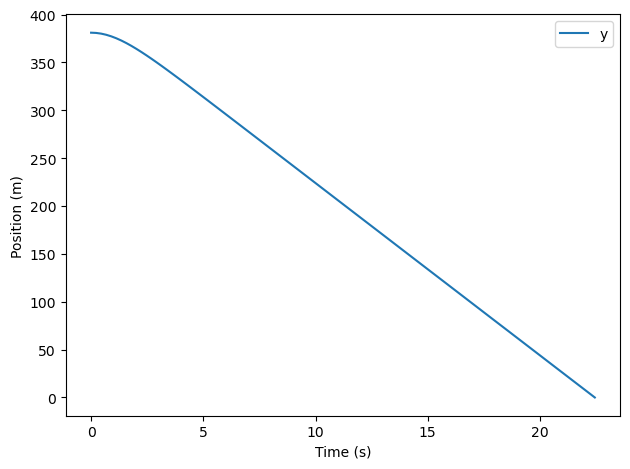

In [75]:
params = Params(
    mass = 0.0025,      # kg
    diameter = 0.019,   # m
    rho = 1.2,          # kg/m**3
    g = 9.8,            # m/s**2
    v_init = 0,         # m / s
    v_term = 18,        # m / s
    height = 381,       # m
    t_end = 30,         # s
)

from numpy import pi

def make_system(params):
    init = State(y=params.height, v=params.v_init)

    area = pi * (params.diameter/2)**2

    C_d = (2 * params.mass * params.g / 
           (params.rho * area * params.v_term**2))

    return System(init=init,
                  area=area,
                  C_d=C_d,
                  mass=params.mass,
                  rho=params.rho,
                  g=params.g,
                  t_end=params.t_end)
    
system = make_system(params)

params2 = params.set(v_term=20)

system2 = make_system(params2)

def slope_func(t, state, system):
    y, v = state
    rho, C_d, area = system.rho, system.C_d, system.area
    mass, g = system.mass, system.g
    
    f_drag = rho * v**2 * C_d * area / 2
    a_drag = f_drag / mass
    
    dydt = v
    dvdt = -g + a_drag
    
    return dydt, dvdt

def event_func(t, state, system):
    y, v = state
    return y

results, details = run_solve_ivp(system, slope_func,
                                 events=event_func)

t_sidewalk = results.index[-1]

def plot_position(results):
    results.y.plot()
        
    decorate(xlabel='Time (s)',
         ylabel='Position (m)')
    
plot_position(results)

t_sidewalk

In [76]:
sweep = linspace(0.010, 0.05, 8)
time = []
for i in sweep:
    params.diameter = i
    print(params)
    system = make_system(params)    
    results, details = run_solve_ivp(system, slope_func, events=event_func)
    time.append(results.index[-1])
    
for i in range(len(time)):
    time[i] = round(time[i], 2)

print(time)
print(sweep)

fig = make_subplots(rows = 1, cols = 1)

fig.add_trace(go.Scatter(x=sweep, y=time, mode='lines'))

fig.show()

Params(mass=0.0025, diameter=0.01, rho=1.2, g=9.8, v_init=0, v_term=18, height=381, t_end=30)
Params(mass=0.0025, diameter=0.015714285714285715, rho=1.2, g=9.8, v_init=0, v_term=18, height=381, t_end=30)
Params(mass=0.0025, diameter=0.02142857142857143, rho=1.2, g=9.8, v_init=0, v_term=18, height=381, t_end=30)
Params(mass=0.0025, diameter=0.027142857142857142, rho=1.2, g=9.8, v_init=0, v_term=18, height=381, t_end=30)
Params(mass=0.0025, diameter=0.032857142857142856, rho=1.2, g=9.8, v_init=0, v_term=18, height=381, t_end=30)
Params(mass=0.0025, diameter=0.03857142857142857, rho=1.2, g=9.8, v_init=0, v_term=18, height=381, t_end=30)
Params(mass=0.0025, diameter=0.04428571428571429, rho=1.2, g=9.8, v_init=0, v_term=18, height=381, t_end=30)
Params(mass=0.0025, diameter=0.05, rho=1.2, g=9.8, v_init=0, v_term=18, height=381, t_end=30)
[22.44, 22.44, 22.44, 22.44, 22.44, 22.44, 22.44, 22.44]
[0.01       0.01571429 0.02142857 0.02714286 0.03285714 0.03857143
 0.04428571 0.05      ]


In [85]:
sweep = linspace(0.010, 0.05, 8)
time = [-18] * 8

fig = make_subplots(rows = 1, cols = 1)

fig.add_trace(go.Scatter(x=sweep, y=time, mode='lines'))

fig.show()

161.60711408721372

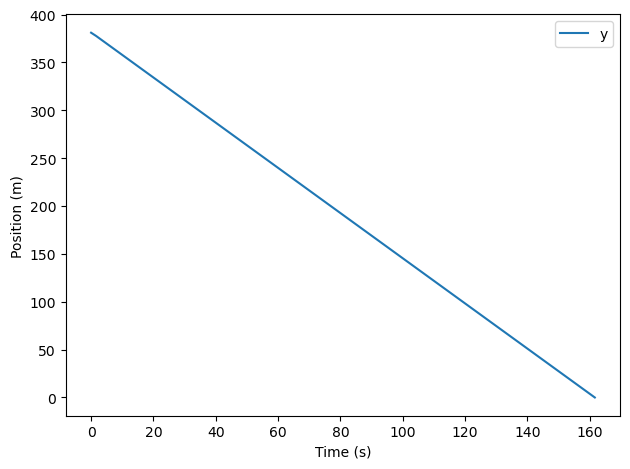

In [84]:
params = Params(
    mass = 1.047,      # kg
    diameter = 1,   # m
    rho = 1,          # kg/m**3
    g = 9.8,            # m/s**2
    v_init = 0,         # m / s
    v_term = 2.36,        # m / s
    height = 381,       # m
    t_end = 200,         # s
)

from numpy import pi

def make_system(params):
    init = State(y=params.height, v=params.v_init)

    area = pi * (params.diameter/2)**2

    C_d = (2 * params.mass * params.g / 
           (params.rho * area * params.v_term**2))

    return System(init=init,
                  area=area,
                  C_d=C_d,
                  mass=params.mass,
                  rho=params.rho,
                  g=params.g,
                  t_end=params.t_end)
    
system = make_system(params)

params2 = params.set(v_term=20)

system2 = make_system(params2)

def slope_func(t, state, system):
    y, v = state
    rho, C_d, area = system.rho, system.C_d, system.area
    mass, g = system.mass, system.g
    
    f_drag = rho * v**2 * C_d * area / 2
    a_drag = f_drag / mass
    
    dydt = v
    dvdt = -g + a_drag
    
    return dydt, dvdt

def event_func(t, state, system):
    y, v = state
    return y

results, details = run_solve_ivp(system, slope_func,
                                 events=event_func)

t_sidewalk = results.index[-1]

def plot_position(results):
    results.y.plot()
        
    decorate(xlabel='Time (s)',
         ylabel='Position (m)')
    
plot_position(results)

t_sidewalk